In [29]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import os
import math
import json

PRECISION = 6

pd.options.display.float_format = '{:,.6f}'.format

1. Wczytanie danych wyjściowych z symulacji -> `looper/simulation/results`

In [30]:
folder_path = '../results'

csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
dataframes = {os.path.splitext(f)[0]: pd.read_csv(os.path.join(folder_path, f)) for f in csv_files}

- Dodanie kolumny z wartościa szukanego optimum i kolumny z wymiarami

In [31]:
with open('../functions.json', 'r') as f:
    functions_minimums = json.load(f)

for name, df in dataframes.items():
    function_name = name.split('_')[0]
    optimum_value = functions_minimums[function_name]['minimum_value']
    dimensions = functions_minimums[function_name]['dimensions']
    df['optimum'] = optimum_value
    df['dimensions'] = dimensions
    df.rename(columns={'iterations': 'iteration'}, inplace=True)

2. Dla każdej kombinacji funkcji i mutacji wyliczenie **MBF**, **BBF** i **WBF**

In [32]:
results = []

for name, df in dataframes.items():
    df_cleared = df.drop(df.columns.difference(['iteration', 'time', 'fitness', 'optimum', 'dimensions']), axis=1)
    df_grouped = df_cleared.groupby('iteration').mean().reset_index()
    
    df_grouped['funkcja'] = name.split('_')[0]
    df_grouped['mutacja'] = name.split('_')[1]
    df_grouped['optimum'] = df['optimum'].iloc[0]
    df_grouped['wymiary'] = df['dimensions'].iloc[0]

    df_grouped.sort_values(by='iteration', inplace=True)
    
    results.append(df_grouped)

results = pd.concat(results)
results.sort_values(by=['funkcja', 'mutacja', 'iteration'], inplace=True)
results


,iteration,time,fitness,optimum,dimensions,funkcja,mutacja,wymiary
0,0,0.000007,19.157070,0,8.000000,ackley,best1bin,8
1,1,0.000457,18.948904,0,8.000000,ackley,best1bin,8
2,2,0.000891,18.621283,0,8.000000,ackley,best1bin,8
3,3,0.001319,18.051057,0,8.000000,ackley,best1bin,8
4,4,0.001740,17.713685,0,8.000000,ackley,best1bin,8
...,...,...,...,...,...,...,...,...
95,95,0.003623,0.000000,0,2.000000,sphere,rand2bin,2
96,96,0.003660,0.000000,0,2.000000,sphere,rand2bin,2
97,97,0.003697,0.000000,0,2.000000,sphere,rand2bin,2
98,98,0.003734,0.000000,0,2.000000,sphere,rand2bin,2


3. Narysuj wykresy MDF, BBF, WBF w zależności od funkcji i mutacji.

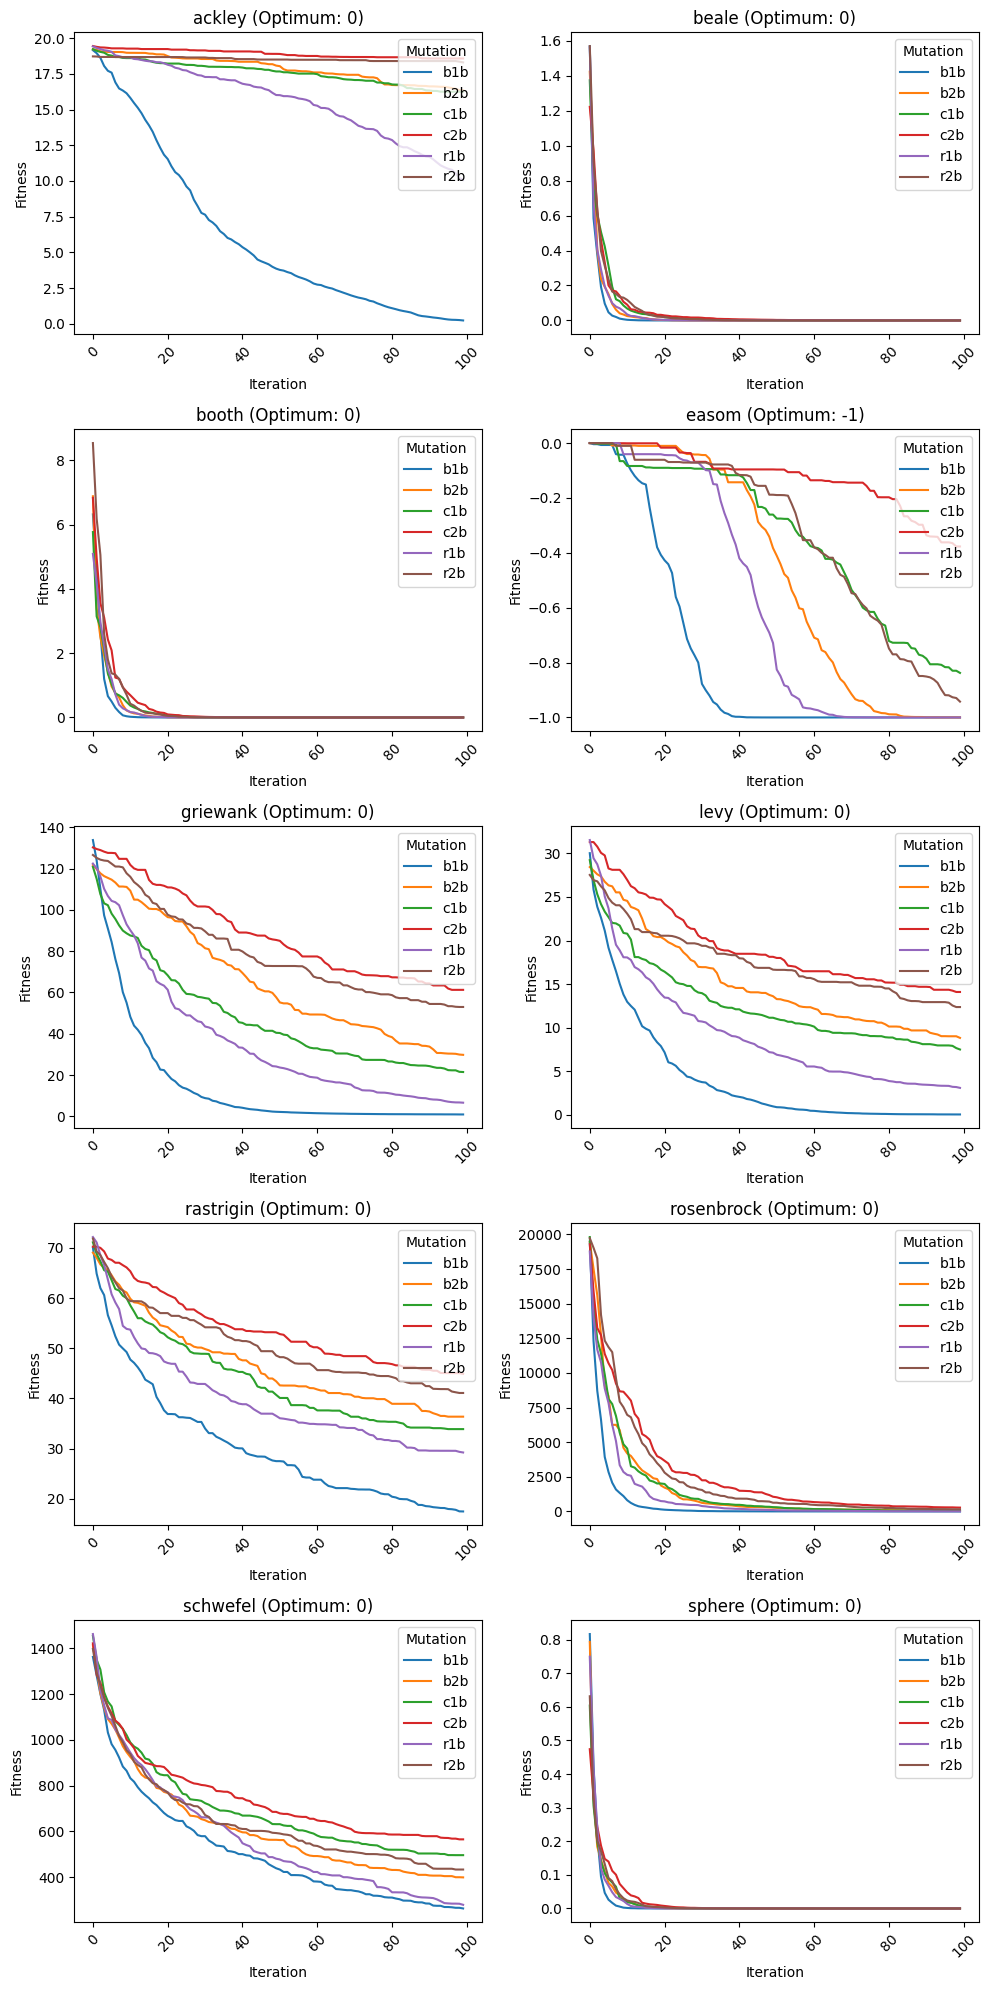

In [34]:
mutation_mapping = {
    'best1bin': 'b1b',
    'best2bin': 'b2b',
    'current1bin': 'c1b',
    'current2bin': 'c2b',
    'rand1bin': 'r1b',
    'rand2bin': 'r2b'
}

functions = results['funkcja'].unique()

n_cols = 2
n_rows = math.ceil(len(functions) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, n_rows * 4))
axes = axes.flatten()

for i, func in enumerate(functions):
    ax = axes[i]
    func_data = results[results['funkcja'] == func]
    
    func_data.loc[:, 'mutacja'] = func_data['mutacja'].replace(mutation_mapping)
    
    for mutation in mutation_mapping.values():
        mutation_data = func_data[func_data['mutacja'] == mutation]
        ax.plot(mutation_data['iteration'], mutation_data['fitness'], label=mutation)
    
    ax.set_title(f"{func} (Optimum: {func_data['optimum'].iloc[0]})")
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Fitness')
    ax.legend(title='Mutation', loc='upper right')
    ax.tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

4. 